# HomeWork 8
**DeadLine : 23:59 29 Aban 1400**

**Total points : 100pts**

# 1. Mount Google Drive

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Make your costome dataset   
 **یادآوری:** این بلوک فقط یکبار اجرا شود تا دیتاست در گوگل درایو ذخیره شود
 از دفعه دوم نیازی به اجرای آن بلوک نیست
 

## 2.1. Download dataset using google scraping

download and install google scraping tools:

In [ ]:
!git clone https://github.com/Joeclinton1/google-images-download.git
!cd /content/google-images-download/ && python setup.py install

costom dataset config:

In [ ]:
!echo '{"Records": [{"keywords": "car","limit": 60,"size": "medium","print_urls": true},{"keywords": "bird","limit": 60,"size": "medium","print_urls": true},{"keywords": "Leopard","limit": 60,"size": "medium","print_urls": true},{"keywords": "cat","limit": 60,"size": "medium","print_urls": true},{"keywords": "dog","limit": 60,"size": "medium","print_urls": true}]}' > dataset.json

download 40-50 image for each category
maybe take 2 or 3 minute ...

In [ ]:
!googleimagesdownload -cf dataset.json

## 2.2 Splite data To train set && test set

In [ ]:
import os
import shutil
categories = ['Leopard', 'bird', 'car', 'cat', 'dog']

os.makedirs('./test/')
for category in categories:
    os.makedirs('./test/'+category)
os.rename('./downloads', './train')

In [ ]:
import os
import shutil

categories = ['Leopard', 'bird', 'car', 'cat', 'dog']
for category in categories:
    src='./train/'+category
    dest='./test/'+category
    src_files = os.listdir(src)
    print(len(src_files))
    i=0
    for file_name in src_files:
        if i > (0.2*(len(src_files))):
            break
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name):
            shutil.move(full_file_name, dest)
        i+=1
        


In [ ]:
for category in categories:
    src='./train/'+category
    dest='./test/'+category
    print(category, 'test imagess: ' ,len(os.listdir(src)))
    print(category, 'test images: ' ,len(os.listdir(dest)))


## 2.2. Copy Training data to Google Drive

In [ ]:
import os
import shutil

destination='/content/drive/MyDrive/HW7_Dataset/'
if not os.path.isdir(destination):
    os.makedirs(destination)
shutil.move('./train/', destination)
shutil.move('./test/', destination)


In [ ]:
for category in categories:
    src=destination+'./train/'+category
    dest=destination+'./test/'+category
    print(category, 'test imagess: ' ,len(os.listdir(src)))
    print(category, 'test images: ' ,len(os.listdir(dest)))


# 3. Load Dataset From Google Drive

In [62]:
categories = ['Leopard', 'bird', 'car', 'cat', 'dog']
import os
import shutil

destination='/content/drive/MyDrive/HW7_Dataset/'
if not os.path.isdir(destination):
    os.makedirs(destination)
os.system('cp -r '+destination+'train/'+ ' ./')
os.system('cp -r '+destination+'test/'+ ' ./')

0

In [63]:
categories = ['Leopard', 'bird', 'car', 'cat', 'dog']
for category in categories:
    src='./train/'+category
    dest='./test/'+category
    print(category, 'test imagess: ' ,len(os.listdir(src)))
    print(category, 'test images: ' ,len(os.listdir(dest)))

Leopard test imagess:  47
Leopard test images:  13
bird test imagess:  47
bird test images:  13
car test imagess:  47
car test images:  13
cat test imagess:  47
cat test images:  13
dog test imagess:  47
dog test images:  13


# 4. Generator

In [64]:
from keras.preprocessing.image import ImageDataGenerator

HEIGHT = 150
WIDTH = 150
BATCH_SIZE = 16

In [65]:
def get_generators(augmentation):
  if augmentation:
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
  else:
    train_datagen = ImageDataGenerator(rescale=1./255)

  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
    './train',
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
  )

  test_generator = test_datagen.flow_from_directory(
    './test',
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
  )

  return [train_generator, test_generator]

In [66]:
[train_generator, test_generator] = get_generators(augmentation=False)
x, y=train_generator.__getitem__(1)
print(x.shape)
print(y.shape)

Found 217 images belonging to 5 classes.
Found 61 images belonging to 5 classes.
(16, 150, 150, 3)
(16, 5)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


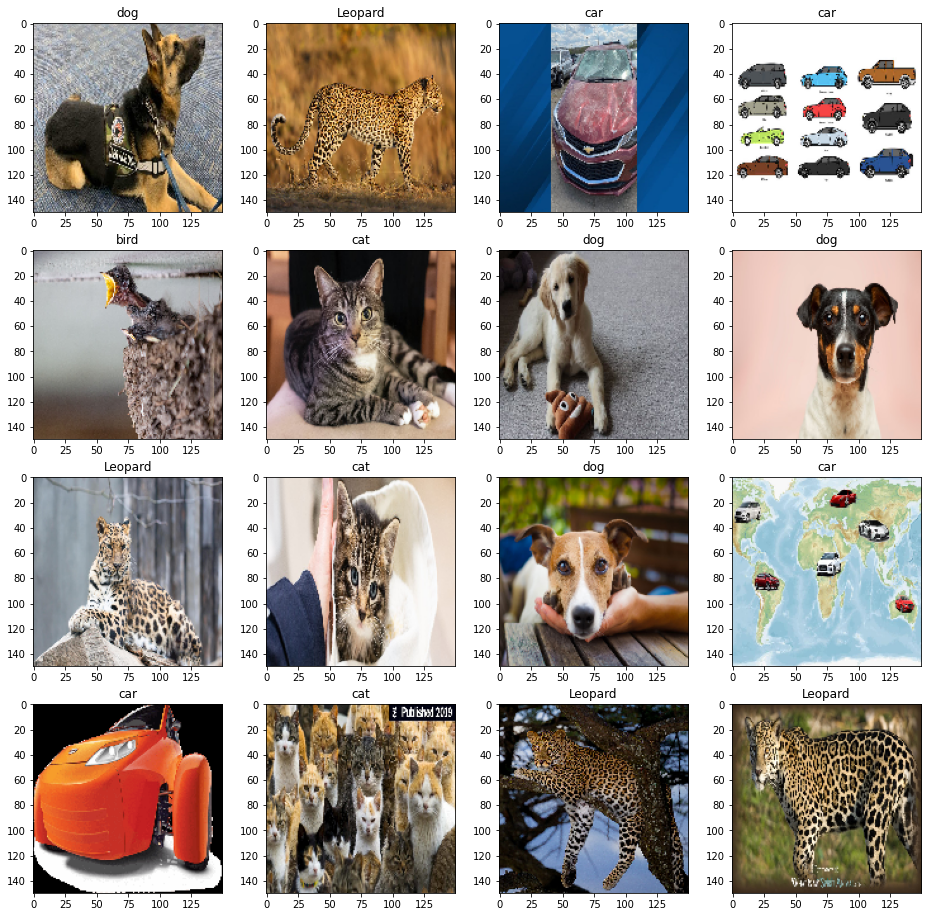

In [67]:
from matplotlib import pyplot as plt
import numpy as np

categories = ['Leopard', 'bird', 'car', 'cat', 'dog']
x, y=train_generator.__getitem__(3)

def plot_img(x_train, y_train):
    from matplotlib import pyplot as plt
    fig=plt.figure(figsize=(16, 16))
    columns = 4
    rows = 4
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        img = x_train[i-1]
        plt.imshow(img)
        plt.title(categories[np.argmax(y[i-1])])
    plt.show()
plot_img(x, y)

# Base model

In [68]:
import glob
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
def plot_results(acc, val_acc, loss, val_loss):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.tight_layout(pad=4)

  ax1.set_title('Accuracy')
  ax1.plot(acc)
  ax1.plot(val_acc)
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['training', 'validation'], loc='lower right')

  ax2.set_title('Loss')
  ax2.plot(loss)
  ax2.plot(val_loss)
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['training', 'validation'], loc='upper right')

  fig.show()

In [70]:
def get_reports(data, model, mode):
  class_labels = data.class_indices
  class_labels = {v:k for k,v in class_labels.items()}
  target_names = list(class_labels.values())

  y_pred = model.predict(data)
  y_pred = np.argmax(y_pred, axis=1)

  cr = classification_report(
    data.classes,
    y_pred,
    target_names=target_names
  )

  cm = confusion_matrix(data.classes, y_pred)

  print(f'\nClassification Report {mode}')
  print(cr)


  print(f'Confusion Matrix {mode}')
  print(cm)

  plt.figure(figsize=(8,8))
  plt.imshow(cm, interpolation='nearest')
  plt.colorbar()
  tick_mark = np.arange(len(target_names))
  _ = plt.xticks(tick_mark, target_names, rotation=90)
  _ = plt.yticks(tick_mark, target_names)

In [71]:
def model_structure(dropout):
  # Model Structure
  input = Input(
      shape=(HEIGHT, WIDTH, 3),
  )

  x = Conv2D(
      filters=32,
      kernel_size=(3, 3),
      strides=(1, 1),
      activation='relu',
  )(input)

  x = MaxPool2D(
      pool_size=(2, 2),
  )(x)

  x = Conv2D(
      filters=32,
      kernel_size=(3, 3),
      strides=(1, 1),
      activation='relu',
  )(x)

  x = MaxPool2D(
      pool_size=(2, 2),
  )(x)

  x = Conv2D(
      filters=64,
      kernel_size=(3, 3),
      strides=(1, 1),
      activation='relu',
  )(x)

  x = MaxPool2D(
      pool_size=(2, 2),
  )(x)

  x = Conv2D(
      filters=64,
      kernel_size=(3, 3),
      strides=(1, 1),
      activation='relu',
  )(x)

  x = Flatten()(x)

  x = Dense(
      units=64,
      activation='relu',
  )(x)

  x = Dropout(rate=dropout)(x)

  output = Dense(
      units=5,
      activation='softmax'
  )(x)

  model = Model(inputs=input, outputs=output)
  return model

In [72]:
model_structure(0.0).summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_60 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 34, 34, 64)        184

In [73]:
def build_model(dropout, dataset):
  # Model Structure
  model = model_structure(dropout)

  # Model Compile
  LOSS = 'categorical_crossentropy'
  OPTIMIZER = Adam(learning_rate=0.001)
  EPOCHS = 50

  model.compile(
      loss=LOSS,
      optimizer=OPTIMIZER,
      metrics=['accuracy'],
  )


  # Model Fit
  CHECKPOINT = ModelCheckpoint(
      filepath='./checkpoints/{epoch:05d}.hdf5',
      monitor='val_accuracy',
      save_best_only=True,
      save_weights_only=False,
      mode='max',
  )
  
  [train_generator, test_generator] = dataset

  history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=test_generator,
      callbacks=[CHECKPOINT],
      verbose=0,
  )


  # Restore Best Model
  list_of_files = glob.glob('./checkpoints/*')
  latest_file = max(list_of_files, key=os.path.getctime)
  best_epoch = latest_file[14:19]
  print('\n\nBest Epoch: ' + str(best_epoch))

  evaluater = load_model(latest_file)

  for f in list_of_files:
    os.remove(f)


  # Evaluation
  print("\nTrain Result")
  evaluater.evaluate(
    train_generator,
    verbose=1,
  )

  print("\nTest Result")
  evaluater.evaluate(
    test_generator,
    verbose=1,
  )


  # Plot Loss and Acc
  print()
  plot_results(
    acc=history.history["accuracy"],
    val_acc=history.history["val_accuracy"],
    loss=history.history["loss"],
    val_loss=history.history["val_loss"],
  )

  return history, evaluater

# Part A: build and train model without using data augmentation

In [74]:
dataset = get_generators(augmentation=False)

Found 217 images belonging to 5 classes.
Found 61 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




Best Epoch: 00020

Train Result
14/14 [==============================] - 4s 245ms/step - loss: 0.0209 - accuracy: 1.0000

Test Result
4/4 [==============================] - 1s 235ms/step - loss: 1.7940 - accuracy: 0.6066



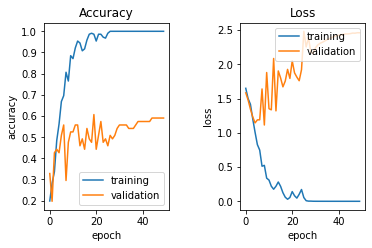

In [75]:
history, best_model = build_model(dropout=0.0, dataset=dataset)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Classification Report Train
              precision    recall  f1-score   support

     Leopard       0.23      0.23      0.23        43
        bird       0.18      0.18      0.18        44
         car       0.10      0.10      0.10        39
         cat       0.20      0.20      0.20        44
         dog       0.30      0.30      0.30        47

    accuracy                           0.21       217
   macro avg       0.20      0.20      0.20       217
weighted avg       0.21      0.21      0.21       217

Confusion Matrix Train
[[10 12  8  7  6]
 [ 8  8 11 10  7]
 [ 6  9  4 12  8]
 [ 8  6  9  9 12]
 [11  9  7  6 14]]


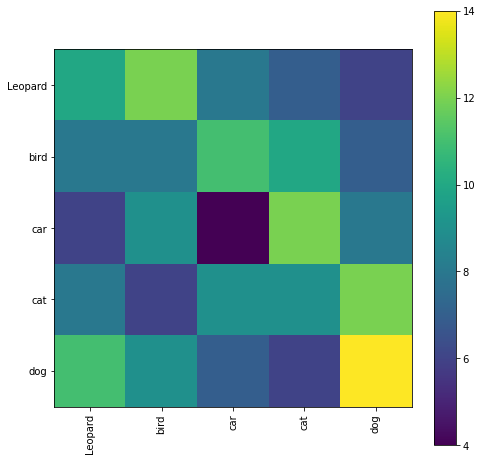

In [76]:
get_reports(dataset[0], model=best_model, mode='Train')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Classification Report Test
              precision    recall  f1-score   support

     Leopard       0.15      0.17      0.16        12
        bird       0.00      0.00      0.00        12
         car       0.36      0.36      0.36        11
         cat       0.50      0.15      0.24        13
         dog       0.28      0.54      0.37        13

    accuracy                           0.25        61
   macro avg       0.26      0.24      0.23        61
weighted avg       0.26      0.25      0.23        61

Confusion Matrix Test
[[2 4 2 0 4]
 [2 0 2 1 7]
 [2 0 4 1 4]
 [4 2 2 2 3]
 [3 2 1 0 7]]


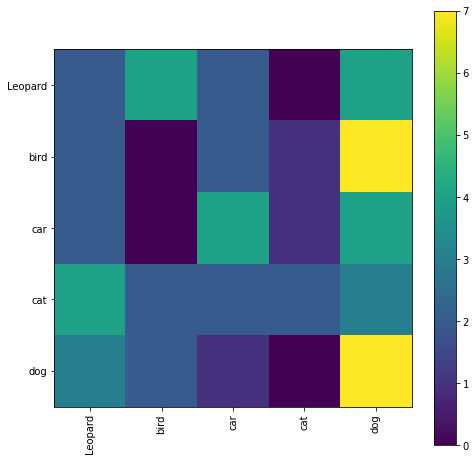

In [77]:
get_reports(dataset[1], model=best_model, mode='Test')

# Part B: train model using data augmentation

In [78]:
dataset = get_generators(augmentation=True)

Found 217 images belonging to 5 classes.
Found 61 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




Best Epoch: 00046

Train Result
14/14 [==============================] - 5s 329ms/step - loss: 0.7311 - accuracy: 0.6912

Test Result
4/4 [==============================] - 1s 209ms/step - loss: 0.9255 - accuracy: 0.7049



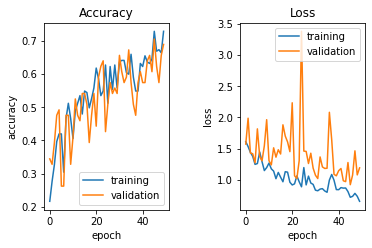

In [79]:
history, best_model = build_model(dropout=0.0, dataset=dataset)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Classification Report Train
              precision    recall  f1-score   support

     Leopard       0.23      0.21      0.22        43
        bird       0.23      0.34      0.28        44
         car       0.31      0.28      0.30        39
         cat       0.24      0.11      0.15        44
         dog       0.21      0.26      0.23        47

    accuracy                           0.24       217
   macro avg       0.24      0.24      0.24       217
weighted avg       0.24      0.24      0.23       217

Confusion Matrix Train
[[ 9 14  4  1 15]
 [ 8 15  8  5  8]
 [ 5 10 11  2 11]
 [ 9 12  7  5 11]
 [ 9 13  5  8 12]]


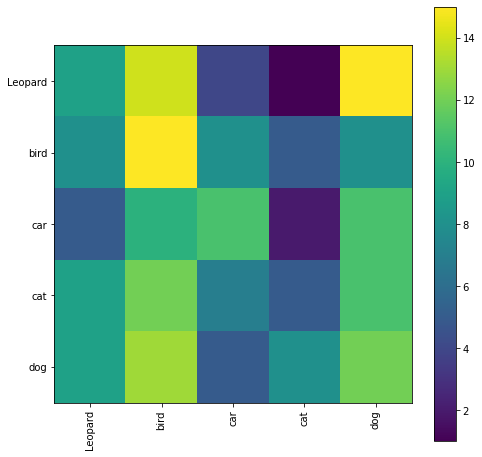

In [80]:
get_reports(dataset[0], model=best_model, mode='Train')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Classification Report Test
              precision    recall  f1-score   support

     Leopard       0.29      0.33      0.31        12
        bird       0.21      0.25      0.23        12
         car       0.20      0.27      0.23        11
         cat       0.17      0.08      0.11        13
         dog       0.33      0.31      0.32        13

    accuracy                           0.25        61
   macro avg       0.24      0.25      0.24        61
weighted avg       0.24      0.25      0.24        61

Confusion Matrix Test
[[4 2 3 1 2]
 [4 3 1 1 3]
 [4 2 3 1 1]
 [1 5 4 1 2]
 [1 2 4 2 4]]


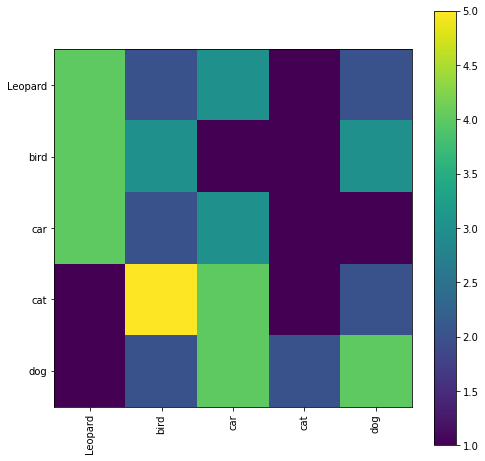

In [81]:
get_reports(dataset[1], model=best_model, mode='Test')

# Part C: build and train model with dropout

In [84]:
dataset = get_generators(augmentation=True)

Found 217 images belonging to 5 classes.
Found 61 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




Best Epoch: 00039

Train Result
14/14 [==============================] - 5s 330ms/step - loss: 0.6547 - accuracy: 0.7235

Test Result
4/4 [==============================] - 1s 215ms/step - loss: 1.2735 - accuracy: 0.6721



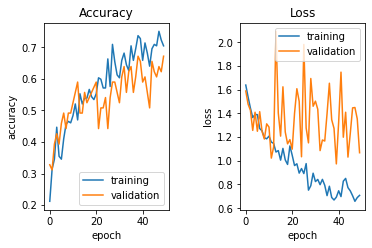

In [85]:
history, best_model = build_model(dropout=0.2, dataset=dataset)

In [86]:
dataset = get_generators(augmentation=True)

Found 217 images belonging to 5 classes.
Found 61 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




Best Epoch: 00048

Train Result
14/14 [==============================] - 5s 333ms/step - loss: 0.9128 - accuracy: 0.6175

Test Result
4/4 [==============================] - 1s 221ms/step - loss: 1.1917 - accuracy: 0.6393



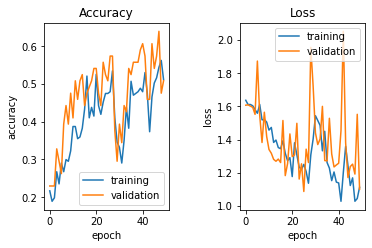

In [87]:
history, best_model = build_model(dropout=0.8, dataset=dataset)

In [88]:
dataset = get_generators(augmentation=True)

Found 217 images belonging to 5 classes.
Found 61 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




Best Epoch: 00038

Train Result
14/14 [==============================] - 5s 329ms/step - loss: 0.8870 - accuracy: 0.6313

Test Result
4/4 [==============================] - 1s 203ms/step - loss: 1.0550 - accuracy: 0.7049



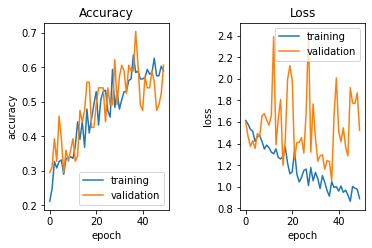

In [89]:
history, best_model = build_model(dropout=0.5, dataset=dataset)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Classification Report Train
              precision    recall  f1-score   support

     Leopard       0.26      0.21      0.23        43
        bird       0.28      0.18      0.22        44
         car       0.36      0.31      0.33        39
         cat       0.31      0.23      0.26        44
         dog       0.18      0.34      0.24        47

    accuracy                           0.25       217
   macro avg       0.28      0.25      0.26       217
weighted avg       0.28      0.25      0.25       217

Confusion Matrix Train
[[ 9  2  5  7 20]
 [ 6  8  6  5 19]
 [ 4  5 12  4 14]
 [ 7  3  4 10 20]
 [ 8 11  6  6 16]]


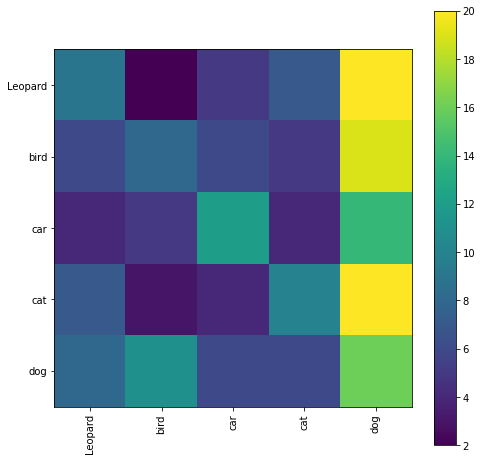

In [90]:
get_reports(dataset[0], model=best_model, mode='Train')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Classification Report Test
              precision    recall  f1-score   support

     Leopard       0.18      0.25      0.21        12
        bird       0.20      0.17      0.18        12
         car       0.07      0.09      0.08        11
         cat       0.00      0.00      0.00        13
         dog       0.19      0.23      0.21        13

    accuracy                           0.15        61
   macro avg       0.13      0.15      0.13        61
weighted avg       0.13      0.15      0.13        61

Confusion Matrix Test
[[3 2 4 0 3]
 [3 2 3 1 3]
 [3 3 1 0 4]
 [5 2 3 0 3]
 [3 1 4 2 3]]


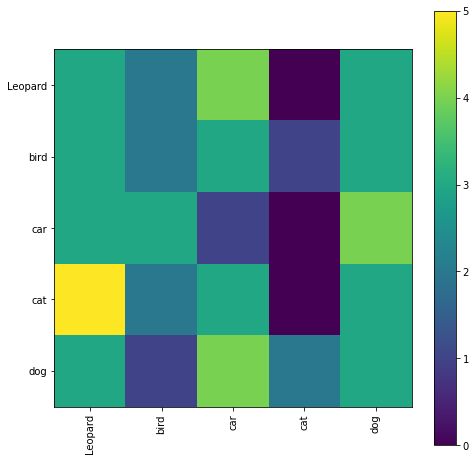

In [91]:
get_reports(dataset[1], model=best_model, mode='Test')